In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
path = os.getcwd() + '/data/'
base_image_path = keras.utils.get_file(path + "paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file(path + "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "./result/paris_generated"

In [3]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

print("width:{}, height:{}".format(width, height))
print("img_nrows:{}, img_ncols:{}".format(img_nrows, img_ncols))

width:910, height:607
img_nrows:400, img_ncols:599


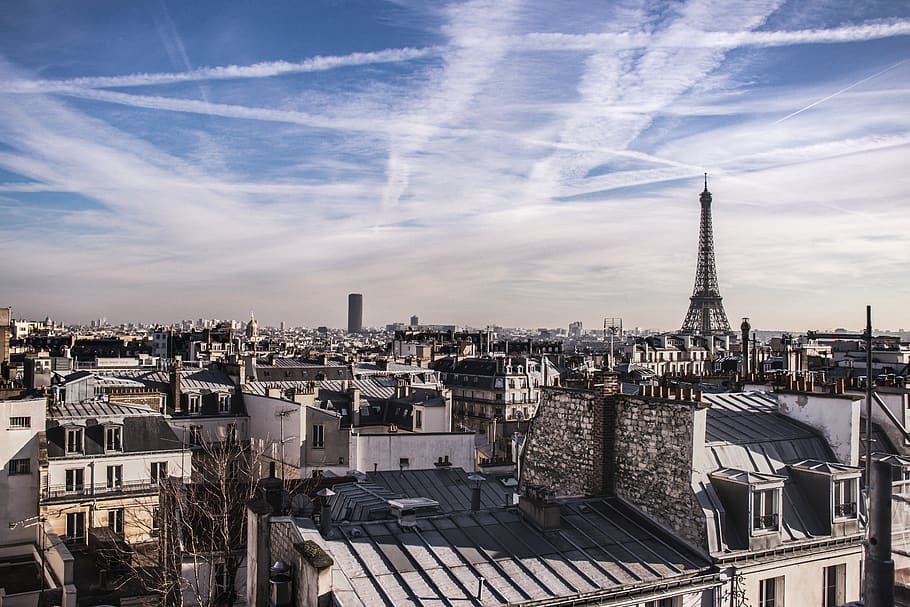

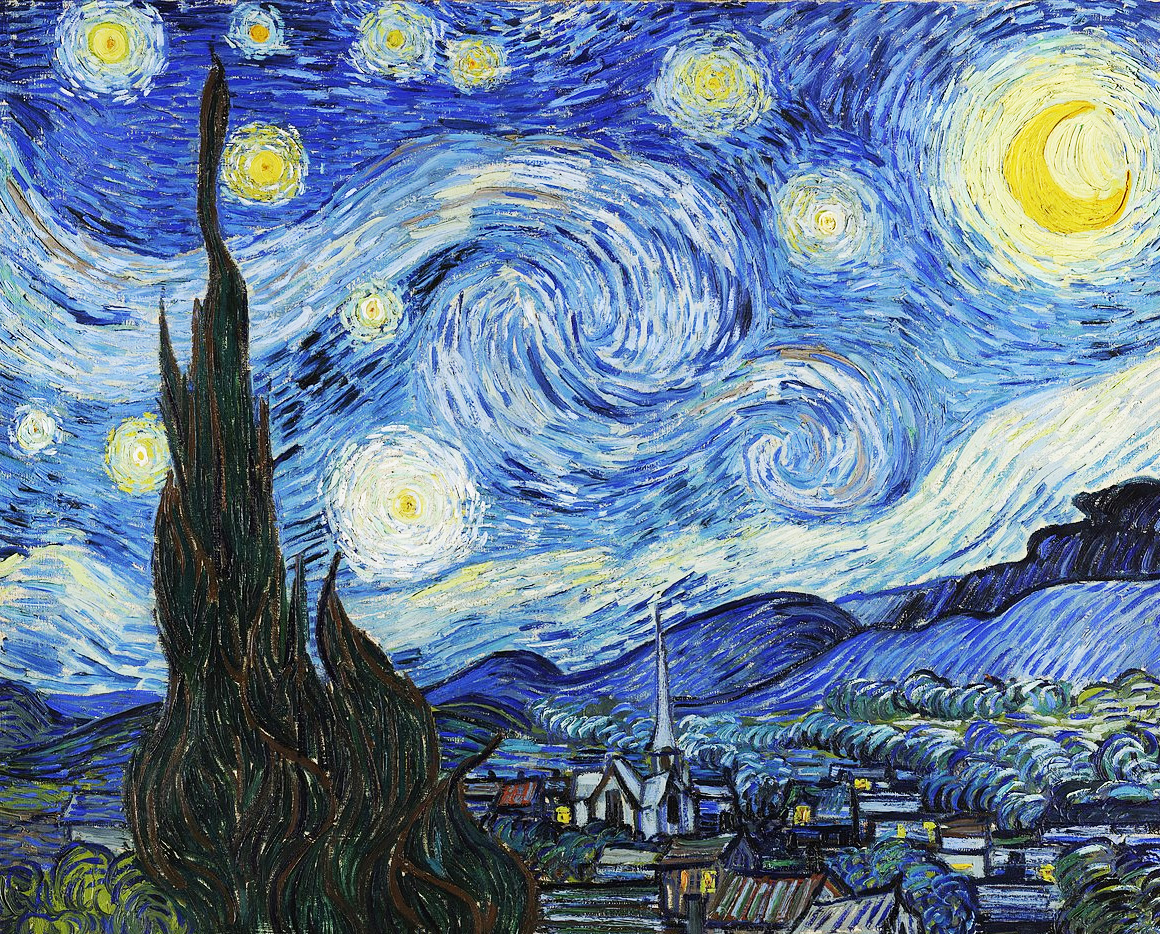

In [4]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    print("after load img, preprocess_image(), img.shape:{}".format(np.shape(img)))
    img = keras.preprocessing.image.img_to_array(img) # convert to numpy array
    img = np.expand_dims(img, axis=0) # input_1's shape (InputLayer) of vgg19 is '[(None, None, None, 3)]'
    print("after expand_dims, preprocess_image(), img.shape:{}".format(img.shape))
    
    '''
    https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/preprocess_input
    1. defaults to "channels_last"
    2. The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
    '''
    img = vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    print("deprocess_image(), x.shape:{}".format(x.shape))
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [6]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    print("before, gram_matrix(), x.shape:{}".format(x.shape))
    x = tf.transpose(x, (2, 0, 1))
    print("after, gram_matrix(), x.shape:{}".format(x.shape))
    
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    print("gram_matrix(), features.shape:{}, tf.transpose(features).shape:{}".format(features.shape, tf.transpose(features).shape))
    
    gram = tf.matmul(features, tf.transpose(features))
    print("gram_matrix(), gram.shape:{}".format(gram.shape))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    print("total_variation_loss(), x.shape:{}".format(x.shape)) # (1, 400, 599, 3)
    a = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :]
    )
    b = tf.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :]
    )
    print("a.shape:{}, b.shape:{}".format(a.shape, b.shape)) # a.shape:(1, 399, 598, 3), b.shape:(1, 399, 598, 3)
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [7]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [8]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image) # dloss_dcombination_image
    return loss, grads

In [10]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))
print("base_image.shape:{}, style_reference_image.shape:{}, combination_image.shape:{}".format(base_image.shape, style_reference_image.shape, combination_image.shape))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

after load img, preprocess_image(), img.shape:(400, 599, 3)
after expand_dims, preprocess_image(), img.shape:(1, 400, 599, 3)
after load img, preprocess_image(), img.shape:(400, 599, 3)
after expand_dims, preprocess_image(), img.shape:(1, 400, 599, 3)
after load img, preprocess_image(), img.shape:(400, 599, 3)
after expand_dims, preprocess_image(), img.shape:(1, 400, 599, 3)
base_image.shape:(1, 400, 599, 3), style_reference_image.shape:(1, 400, 599, 3), combination_image.shape:(1, 400, 599, 3)
before, gram_matrix(), x.shape:(400, 599, 64)
after, gram_matrix(), x.shape:(64, 400, 599)
gram_matrix(), features.shape:(64, 239600), tf.transpose(features).shape:(239600, 64)
gram_matrix(), gram.shape:(64, 64)
before, gram_matrix(), x.shape:(400, 599, 64)
after, gram_matrix(), x.shape:(64, 400, 599)
gram_matrix(), features.shape:(64, 239600), tf.transpose(features).shape:(239600, 64)
gram_matrix(), gram.shape:(64, 64)
before, gram_matrix(), x.shape:(200, 299, 128)
after, gram_matrix(), x.shape

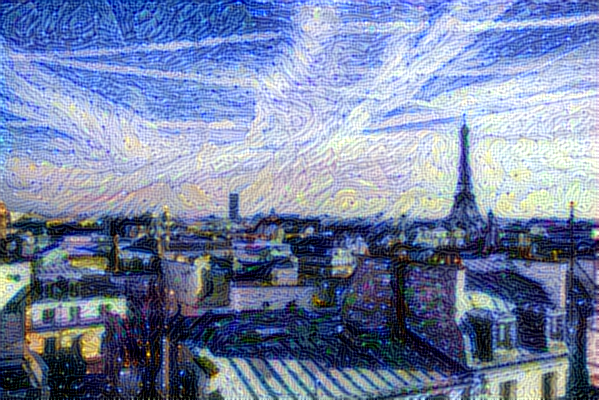

In [11]:
display(Image(result_prefix + "_at_iteration_4000.png"))